## Bibliotecas e dados

In [79]:
# import statsmodels.api as sm
# import statsmodels.tsa.api as tsa
# from statsmodels.tsa.ar_model import AutoReg
# from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import pmdarima as pm
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
# import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

#mpl.rcParams['figure.figsize'] = [10, 5]

def show_metrics(y_test,prediction, results, name):
    print(f'{name} - model Results')
    print('r2' , r2_score(prediction, y_test))
    print('mse' ,mean_squared_error(prediction, y_test))
    print('mae', mean_absolute_error(prediction, y_test))
    results[name] = {'r2':r2_score(prediction, y_test), \
                    'mse': mean_squared_error(prediction, y_test), 
                    'mae': mean_absolute_error(prediction, y_test)}

In [ ]:
#df = pd.read_csv("chuva_fortaleza.csv")
#df.set_index(df['Year'], inplace=True) 
#df = df.drop('Year', 1)
#df = df['Milimitros']
#df.plot()
#df.head()

In [80]:
#https://www.kaggle.com/datasets/mahirkukreja/delhi-weather-data
df = pd.read_csv("temp_dehli.csv")

In [81]:
df = df[["date", "meantemp"]]
df['date'] = pd.to_datetime(df['date'], format='%m/%d/%Y')
df.set_index(df['date'], inplace=True) 
df = df.drop('date', 1)
# df = df['meantemp']


/var/folders/1m/y3z71pwn1gj1xgby2r8jtfcm0000gn/T/ipykernel_4020/3726606635.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop('date', 1)


In [ ]:
df.head()

Separando dados em treino, teste e validação. Vale notar que para os modelos lineares utilizaremos apenas treino (75%) e teste (25%), enquanto que para os modelos de machine learning utilizaremos treino (50%), validação (25%) e teste (25%).

In [ ]:
df_train = df.iloc[:int(len(df) * 0.75)]
df_test = df.iloc[int(len(df) * 0.75):]

#df_train2 = df.iloc[:int(len(df) * 0.5)]
#df_valid2 = df.iloc[int(len(df) * 0.5):int(len(df) * 0.75)]
#df_test2 = df.iloc[int(len(df) * 0.75):]

## Plot

In [ ]:
df.plot()

## Decomposição

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9
df_decomp = tsa.seasonal_decompose(df, period=365)
df_decomp.plot()

## Estacionariedade

In [ ]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(df, regression='ct')
print(pvalue)
print(lags)

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# Augmented Dickey Fuller (ADF) Test
result = adfuller(df['meantemp'].values, autolag='AIC')
print('ADF Statistic:', result[0], 'p-value:', result[1])

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
result = kpss(df['meantemp'].values, nlags="auto", regression='c')
print('KPSS Statistic: ', result[0], 'p-value: ', result[1])

In [ ]:
from statsmodels.tsa.stattools import adfuller, kpss

# Augmented Dickey Fuller (ADF) Test
result = adfuller(dfd1['meantemp'].values, autolag='AIC')
print('ADF Statistic:', result[0], 'p-value:', result[1])

# Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test
result = kpss(dfd1['meantemp'].values, nlags="auto", regression='c')
print('KPSS Statistic: ', result[0], 'p-value: ', result[1])

## Diferenciação

In [ ]:
df.diff().plot()

In [ ]:
df.diff().plot.hist()

In [ ]:
dfd1 = df.diff().dropna()

In [ ]:
test, pvalue, lags, obs, critic, ic = tsa.stattools.adfuller(dfd1, regression='ct')
print(pvalue)
print(lags)

## Autocorrelação

### Correlação

In [ ]:
df.corrwith(df.shift(1))

In [ ]:
plot_acf(df)

Correlação com série diferenciada

In [ ]:
dfd1.corrwith(dfd1.shift(1))

In [ ]:
plot_acf(dfd1)

## Autocorrelação Parcial

In [ ]:
plot_pacf(df)

Correlação Parcial com série diferenciada

In [ ]:
plot_pacf(dfd1)

### ARIMA

ARIMA (5,1,3)

In [ ]:
df_train.index = pd.DatetimeIndex(df_train.index.values, freq=df_train.index.inferred_freq)
df_train.head()

In [ ]:
arima_model = ARIMA(df_train, order=(5,1,3))

In [ ]:
res_arima = arima_model.fit()

In [ ]:
res_arima.summary()

In [ ]:
res_arima.plot_diagnostics()

In [ ]:
#Previsão do treino
fig, ax = plt.subplots()
ax.plot(res_arima.predict(), label='pred')
ax.plot(df_train, label='true')
plt.title('Dehli - ARIMA (5,1,3) - Treino')
plt.legend()

In [ ]:
res_arima.forecast()

In [ ]:
# Build Model 
#model = ARIMA(df_train, order=(2, 0, 1))  
fitted = res_arima  

# Forecast
fc = fitted.forecast(394, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='treino')
plt.plot(df_test, label='test')
plt.plot(fc_series, label='predicao')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
import numpy as np

fitted = res_arima  
fc = fitted.get_forecast(len(df['meantemp'][int(np.floor((len(df)/100)*75)):]))  
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean, index=df_test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=df_test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
results = {}

In [ ]:
print('model Results')
print('r2' , r2_score(forecast, df_test))
print('mse' ,mean_squared_error(forecast, df_test))
print('mae', mean_absolute_error(forecast, df_test))
results['MA'] = {'r2':r2_score(forecast, df_test), \
                 'mse': mean_squared_error(forecast, df_test), 
                 'mae': mean_absolute_error(forecast, df_test)}

### Auto ARIMA

In [ ]:
auto_arima = pm.auto_arima(df_train, max_ar=10, max_ma=5, max_d=2, seasonal=False, trace=True, stepwise=True)

In [ ]:
auto_arima.summary()

In [ ]:
auto_arima.plot_diagnostics()

In [ ]:
fig, ax = plt.subplots()
ax.plot(auto_arima.predict_in_sample(), label='pred')
ax.plot(df_train.values, label='true')
plt.title('Dehli - Auto ARIMA MODEL')
plt.legend()

In [ ]:
fig, ax = plt.subplots()
ax.plot(pd.DataFrame(auto_arima.predict(n_periods=394), index=df_test.index), label='pred')
#ax.plot(df_train.values, label='true')
ax.plot(df_train, label='true')
plt.title('Dehli - Auto ARIMA MODEL')
plt.legend()

In [ ]:
pred = auto_arima.predict(n_periods=394)

print('MA model Results')
print('r2' , r2_score(pred, df_test))
print('mse' ,mean_squared_error(pred, df_test))
print('mae', mean_absolute_error(pred, df_test))
results['MA'] = {'r2':r2_score(pred, df_test), \
                 'mse': mean_squared_error(pred, df_test), 
                 'mae': mean_absolute_error(pred, df_test)}

In [ ]:
# Build Model 
model = ARIMA(df_train, order=(2, 0, 1))  
fitted = model.fit()  

# Forecast
fc = fitted.forecast(394, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [ ]:
import numpy as np

model = ARIMA(df_train, order=(2, 0, 1))  
fitted = model.fit()  

fc = fitted.get_forecast(len(df['meantemp'][int(np.floor((len(df)/100)*75)):]))  
conf = fc.conf_int(alpha=0.05) # 95% confidence

fc_series = pd.Series(fc.predicted_mean, index=df_test.index)
lower_series = pd.Series(conf.iloc[:, 0], index=df_test.index)
upper_series = pd.Series(conf.iloc[:, 1], index=df_test.index)

# Plot
plt.figure(figsize=(12,5), dpi=200)
plt.plot(df_train, label='training')
plt.plot(df_test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

## Machine Learning

### Feature Engineering

In [100]:
#time travel
def get_lags(series, lags):
  result = []
  if lags > 0:
    for lag in range(1, lags+1):
    #  print(lag)
    #  print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'-'+str(lag)}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(-1,-lags))).dropna()
  else:
    for lag in range(-1, lags-1,-1):
      #print(lag)
      #print(series.shift(lag))
      result.append(series.shift(lag).rename({series.columns[0]: series.columns[0]+'+'+str(abs(lag))}, axis=1))
    #return result
    return pd.concat(result, axis=1, names=list(range(+1,-lags))).dropna()

In [101]:
X = get_lags(df, 5)
X.head()

,meantemp-1,meantemp-2,meantemp-3,meantemp-4,meantemp-5
date,,,,,
2013-01-06,6.000000,8.666667,7.166667,7.400000,10.000000
2013-01-07,7.000000,6.000000,8.666667,7.166667,7.400000
2013-01-08,7.000000,7.000000,6.000000,8.666667,7.166667
2013-01-09,8.857143,7.000000,7.000000,6.000000,8.666667
2013-01-10,14.000000,8.857143,7.000000,7.000000,6.000000


In [102]:
y = df.reindex(X.index)
y.head()

,meantemp
date,
2013-01-06,7.000000
2013-01-07,7.000000
2013-01-08,8.857143
2013-01-09,14.000000
2013-01-10,11.000000


In [ ]:
#Separando os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)

### KNN

Utilizaremos o GridSearch para encontrar os melhores parâmetros para o NKK.

In [ ]:
#Definindo hiperpâmetros de busca do GridSearch
parameters = {'n_neighbors':range(1,20), 'weights':["uniform", "distance"]}
for p in parameters.items():
  print(p)

In [ ]:
knn = KNeighborsRegressor()
knnGS = GridSearchCV(knn, parameters, cv=TimeSeriesSplit(n_splits=10))
res = knnGS.fit(X_train, y_train)
print(res.best_score_)
print(res.best_params_)

Métricas

In [ ]:
prediction = res.predict(X_test)
show_metrics(y_test, prediction, results, 'KNN GS')

In [ ]:
fig, ax = plt.subplots()
ax.plot(prediction, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('Dehli Temperature - KNN GS MODEL')
plt.legend()

In [ ]:
residuos = prediction.flatten() - y_test.reset_index(drop=True).values.flatten()
pd.Series(residuos).plot()

In [ ]:
pd.Series(residuos).plot.kde()

In [ ]:
plot_acf(residuos)

KNN com série difenciada

In [ ]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_test_d1 = y_test.diff().dropna()

In [ ]:
res_diff = knnGS.fit(X_train_d1, y_train_d1)
print(res_diff.best_score_)
print(res_diff.best_params_)

In [ ]:
prediction_diff = res_diff.predict(X_test_d1)
show_metrics(y_test_d1, prediction_diff, results, 'd1 KNN GS')

In [ ]:
fig, ax = plt.subplots()
ax.plot(pd.Series(prediction_diff.flatten()), label='pred')
ax.plot(y_test_d1.reset_index(drop=True), label='true')
plt.legend()

One step ahead

In [ ]:
fig, ax = plt.subplots()
ax.plot(pd.Series(prediction_diff.flatten()).cumsum(), label='pred')
ax.plot(y_test_d1.reset_index(drop=True).cumsum(), label='true')
plt.legend()

In [ ]:
pred_one = y_test.shift(1).reset_index(drop=True).add(pd.Series(prediction_diff.flatten(), name='temperature'),axis=0)


In [ ]:
fig, ax = plt.subplots()
ax.plot(pred_one, label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.legend()

In [ ]:
show_metrics(y_test.iloc[1:-1], pred_one.iloc[1:-1], results, 'pred one KNN GS')

In [ ]:
residuos = prediction_diff.flatten() - y_test_d1.reset_index(drop=True).values.flatten()

In [ ]:
pd.Series(residuos).plot()

In [ ]:
pd.Series(residuos).plot.kde()

In [ ]:
plot_acf(residuos)

### Support Vector Regression

In [ ]:
from sklearn.svm import SVR

regr = SVR(C=1.0, epsilon=0.2, kernel='linear')

regr.fit(X_train, y_train)

In [ ]:
mean_absolute_error(regr.predict(X_test), y_test)

In [ ]:
print('El Nino - SVR model Results')
print(r2_score(regr.predict(X_test), y_test))
print(mean_squared_error(regr.predict(X_test), y_test))
print(mean_absolute_error(regr.predict(X_test), y_test))
results['SVR'] = {'r2':r2_score(regr.predict(X_test), y_test), \
                 'mse': mean_squared_error(regr.predict(X_test), y_test), 
                 'mae': mean_absolute_error(regr.predict(X_test), y_test)}

In [ ]:
fig, ax = plt.subplots()
ax.plot(regr.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('EL NINO - SVR MODEL')
plt.legend()

#### Grid Search (TODO: testar outros parametros) 

In [ ]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

In [ ]:
parameters = {'kernel':['linear','rbf'], 'C':[0.1,1,10]}
for p in parameters.items():
  print(p)

In [ ]:
regr2 = SVR()
regrGS = GridSearchCV(regr2, parameters, cv=TimeSeriesSplit())

In [ ]:
#%%time
res = regrGS.fit(X_train, y_train)

In [ ]:
print(res.best_score_)
print(res.best_params_)

In [ ]:
print('SVR GS - model Results')
print('r2' , r2_score(res.predict(X_test), y_test))
print('mse' ,mean_squared_error(res.predict(X_test), y_test))
print('mae', mean_absolute_error(res.predict(X_test), y_test))
results['SVRGS'] = {'r2':r2_score(res.predict(X_test), y_test), \
                 'mse': mean_squared_error(res.predict(X_test), y_test), 
                 'mae': mean_absolute_error(res.predict(X_test), y_test)}

In [ ]:
fig, ax = plt.subplots()
ax.plot(res.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('EL NINO - SVR GS MODEL')
plt.legend()

In [ ]:
pd.DataFrame(results)

In [ ]:
X = get_lags(df, 5)
y = df.reindex(X.index)
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.2)

In [ ]:
regrco2 = SVR(kernel='linear')
regrco2.fit(X_train, y_train)

In [ ]:
print('SVR GS - model Results')
print('r2' , r2_score(regrco2.predict(X_test), y_test))
print('mse' ,mean_squared_error(regrco2.predict(X_test), y_test))
print('mae', mean_absolute_error(regrco2.predict(X_test), y_test))
results['SVRGS'] = {'r2':r2_score(regrco2.predict(X_test), y_test), \
                 'mse': mean_squared_error(regrco2.predict(X_test), y_test), 
                 'mae': mean_absolute_error(regrco2.predict(X_test), y_test)}

In [ ]:
fig, ax = plt.subplots()
ax.plot(regrco2.predict(X_test), label='pred')
ax.plot(y_test.reset_index(drop=True), label='true')
plt.title('CO2 - SVR GS MODEL')
plt.legend()

In [ ]:
pd.DataFrame(results)

#### TODO: Verificar se há Overfitting

In [ ]:
from sklearn.model_selection import learning_curve
import numpy as np

In [ ]:
train_sizes, train_scores, valid_scores = learning_curve(
    SVR(kernel='linear'), X, y, train_sizes=[50,100,150,200,250], cv=TimeSeriesSplit())
    #SVR(kernel='linear'), X, y, train_sizes=[np.round(np.array(list(range(0.1,1,0.1))) * len(y))], cv=TimeSeriesSplit())

In [ ]:
pd.Series(train_scores.mean(axis=1), index=train_sizes).plot(label='train')
pd.Series(valid_scores.mean(axis=1), index=train_sizes).plot(label='val')
plt.legend()

### MLP (TODO: testar arquiteturas e tuning)

In [93]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim

#### Divisão de Dados MLP 

In [103]:
#Separando os dados
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=.25)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=.25)

#### Diferenciação

In [104]:
#Diferenciando
X_train_d1 = X_train.diff().dropna()
X_valid_d1 = X_valid.diff().dropna()
X_test_d1 = X_test.diff().dropna()
y_train_d1 = y_train.diff().dropna()
y_valid_d1 = y_valid.diff().dropna()
y_test_d1 = y_test.diff().dropna()

#### Normalização

In [105]:
X_train_d1_norm = X_train_d1.sub(X_train_d1.mean()).div(X_train_d1.std())
X_valid_d1_norm = X_valid_d1.sub(X_valid_d1.mean()).div(X_valid_d1.std())
X_test_d1_norm = X_test_d1.sub(X_train_d1.mean()).div(X_train_d1.std())

<AxesSubplot:xlabel='date'>

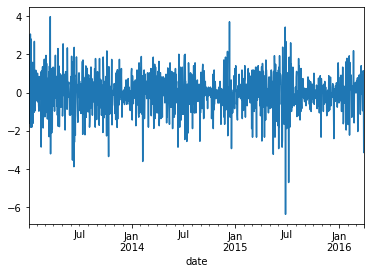

In [86]:
X_train_d1_norm['meantemp-1'].plot()

<AxesSubplot:title={'center':'train'}, ylabel='Frequency'>

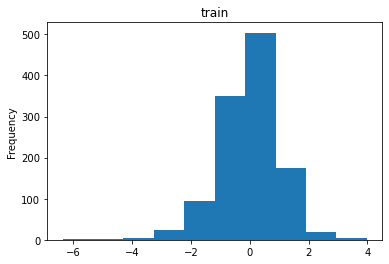

In [87]:
X_train_d1_norm['meantemp-1'].plot.hist(title='train')

<AxesSubplot:title={'center':'validation'}, ylabel='Frequency'>

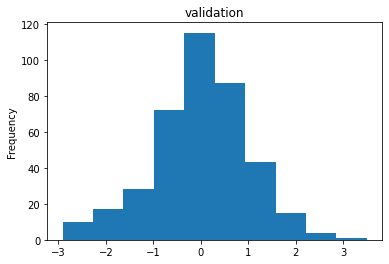

In [88]:
X_valid_d1_norm['meantemp-1'].plot.hist(title='validation')

<AxesSubplot:title={'center':'test'}, ylabel='Frequency'>

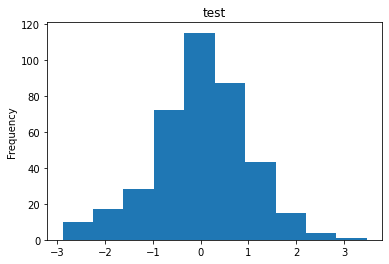

In [89]:
X_test_d1_norm['meantemp-1'].plot.hist(title='test')


#### Batches

In [106]:
training_data = torch.tensor(pd.concat([X_train_d1_norm, y_train_d1], axis=1).values)
validating_data = torch.tensor(pd.concat([X_valid_d1_norm, y_valid_d1], axis=1).values)
testing_data = torch.tensor(pd.concat([X_test_d1_norm, y_test_d1], axis=1).values)


In [107]:
train_dataloader = DataLoader(training_data, batch_size=16, shuffle=False)
valid_dataloader = DataLoader(validating_data, batch_size=16, shuffle=False)
test_dataloader = DataLoader(testing_data, batch_size=16, shuffle=False)

#### Modelo MLP

In [123]:
class MLP(nn.Module):
  def __init__(self):
    super().__init__()
    
    #Config 1
    # self.fc1 = nn.Linear(5,100)
    # self.fc3 = nn.Linear(100,1)
    
    #Config 2
    # self.fc1 = nn.Linear(5,32)
    # self.fc2 = nn.Linear(32,64)
    # self.fc3 = nn.Linear(64,1)
     
    # #Config 3
    self.fc1 = nn.Linear(5,32)
    self.drop1 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(32,64)
    self.drop2 = nn.Dropout(p=0.5)
    self.fc3 = nn.Linear(64,1)
  
  def forward(self, X):
    out = torch.tanh(self.fc1(X))
    out = self.drop1(out)
    out = torch.relu(self.fc2(out))
    out = self.drop2(out)
    out = self.fc3(out)
    return out

In [124]:
multi_neuron = MLP()
print(multi_neuron(torch.tensor(X_train_d1.iloc[0]).float()))
print(y_train_d1.iloc[0])

tensor([0.4015], grad_fn=<AddBackward0>)
meantemp    0.0
Name: 2013-01-07 00:00:00, dtype: float64


In [125]:
multi_neuron = MLP()
epochs = 300
loss_fn = nn.MSELoss()
#optimizer = optim.RMSprop(multi_neuron.parameters(), lr=0.001)
optimizer = optim.SGD(multi_neuron.parameters(), lr=0.01, weight_decay= 0.005)

/Users/mariamaoliveira/opt/anaconda3/envs/data_science/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([16])) that is different to the input size (torch.Size([16, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/mariamaoliveira/opt/anaconda3/envs/data_science/lib/python3.9/site-packages/torch/nn/modules/loss.py:529: UserWarning: Using a target size (torch.Size([8])) that is different to the input size (torch.Size([8, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch10, loss 2.806310712082966
Epoch20, loss 2.8040364650455682
Epoch30, loss 2.8032981294232444
Epoch40, loss 2.8041004506317346
Epoch50, loss 2.8033433661267564
Epoch60, loss 2.80355962345729
Epoch70, loss 2.8036647745080896
Epoch80, loss 2.8037336947950156
Epoch90, loss 2.8033709876440667
Epoch100, loss 2.802748011576163
Epoch110, loss 2.8036150751081674
Epoch120, loss 2.802736642392906
Epoch130, loss 2.8021708364422255
Epoch140, loss 2.8022350290337124
Epoch150, loss 2.80260770304783
Epoch160, loss 2.8024158292525523
Epoch170, loss 2.802057949675096
Epoch180, loss 2.8027455319423935
Epoch190, loss 2.8020873859121993
Epoch200, loss 2.8026748078094945
Epoch210, loss 2.8017204303193735
Epoch220, loss 2.802020596491324
Epoch230, loss 2.8026950685559093
Epoch240, loss 2.801646684472625
Epoch250, loss 2.802340955347628
Epoch260, loss 2.802010197091747
Epoch270, loss 2.8021158294097797
Epoch280, loss 2.8018214903973244
Epoch290, loss 2.8023243083341702
Epoch300, loss 2.801754602306598


<AxesSubplot:>

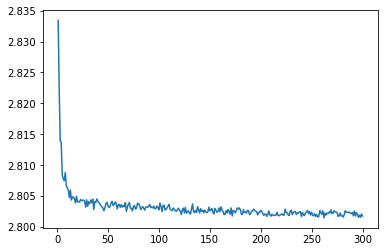

In [126]:
history = {}
for epoch in range(1, epochs+1):
  loss_train = 0.0
  for train_data in train_dataloader:
    x = train_data[:,:5].float()
    y = train_data[:,5].float()
  
    #forward pass
    outputs = multi_neuron(x)

    #loss measure
    loss = loss_fn(outputs,y)

    #backward pass
    optimizer.zero_grad() # pára o autograd
    loss.backward() # executa o backpropagation
    optimizer.step() # atualiza os pesos

    loss_train += loss.item() # soma os erros para obter o erro total

  if (epoch % 10 == 0):
    print('Epoch{}, loss {}'.format(epoch, loss_train / len(train_dataloader))) # apresenta o erro médio da época
  history[epoch] = loss_train / len(train_dataloader)

pd.Series(history).plot()

In [127]:
multi_neuron.eval()
results_MLP = []
for test_data in test_dataloader:
    x = test_data[:,:5].float()
    y = test_data[:,5].float()
    
    y_pred = multi_neuron(x)
    results_MLP.extend(y_pred.flatten().detach().numpy())
#pd.DataFrame(results).plot()
results_MLP[:10]

[0.0064423922,
 -0.00725775,
 0.032014534,
 0.09379335,
 0.075457975,
 0.10825218,
 0.104938045,
 0.05332236,
 0.02655861,
 -0.005702869]

<AxesSubplot:>

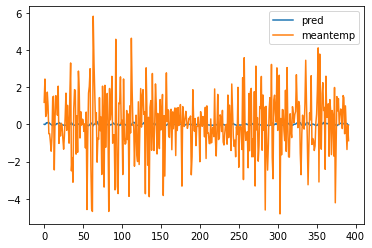

In [128]:
pd.concat([pd.Series(results_MLP, name='pred'), y_test_d1.reset_index(drop=True)],axis=1).plot()

In [129]:
print('Prices - MLP Results')
print('r2' ,r2_score(results_MLP, y_test_d1))
print('mse' ,mean_squared_error(results_MLP, y_test_d1))
print('mae', mean_absolute_error(results_MLP, y_test_d1))
results['MLP'] = {'r2':r2_score(results_MLP, y_test_d1), \
                 'mse': mean_squared_error(results_MLP, y_test_d1), 
                 'mae': mean_absolute_error(results_MLP, y_test_d1)}

Prices - MLP Results
r2 -1483.9882970797798
mse 2.7867264167991235
mae 1.268333668417989


In [ ]:
pd.DataFrame(results)